In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt

import airportsdata

%matplotlib inline

In [2]:
data = pd.read_csv(f'data{os.sep}flight_delays_train.csv')
data.head()

,Month,DayofMonth,DayOfWeek,DepTime,UniqueCarrier,Origin,Dest,Distance,dep_delayed_15min
0,c-8,c-21,c-7,1934,AA,ATL,DFW,732,N
1,c-4,c-20,c-3,1548,US,PIT,MCO,834,N
2,c-9,c-2,c-5,1422,XE,RDU,CLE,416,N
3,c-11,c-25,c-6,1015,OO,DEN,MEM,872,N
4,c-10,c-7,c-6,1828,WN,MDW,OMA,423,Y


In [3]:
df = data.copy()

# Preprocessing

In [4]:
df['Month'] = data['Month'].apply(lambda x: int(x.split('-')[1]))
df['DayofMonth'] = data['DayofMonth'].apply(lambda x: int(x.split('-')[1]))
df['DayOfWeek'] = data['DayOfWeek'].apply(lambda x: int(x.split('-')[1]))
df['DepTime'] = data['DepTime'].apply(lambda x: x % 2400)

In [5]:
df.head()

,Month,DayofMonth,DayOfWeek,DepTime,UniqueCarrier,Origin,Dest,Distance,dep_delayed_15min
0,8,21,7,1934,AA,ATL,DFW,732,N
1,4,20,3,1548,US,PIT,MCO,834,N
2,9,2,5,1422,XE,RDU,CLE,416,N
3,11,25,6,1015,OO,DEN,MEM,872,N
4,10,7,6,1828,WN,MDW,OMA,423,Y


### Quantile Discretization ?

In [6]:
df['DepTime'] = pd.qcut(x=data['DepTime'], q=4, labels=['Night', 'Morning', 'Afternoon', 'Evening'])

In [7]:
df['DepTime']

0          Evening
1        Afternoon
2        Afternoon
3          Morning
4          Evening
           ...    
99995    Afternoon
99996        Night
99997      Evening
99998    Afternoon
99999      Evening
Name: DepTime, Length: 100000, dtype: category
Categories (4, object): ['Night' < 'Morning' < 'Afternoon' < 'Evening']

/tmp/ipykernel_36262/1187805376.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df[['DepTime', 'dep_delayed_15min']].groupby(


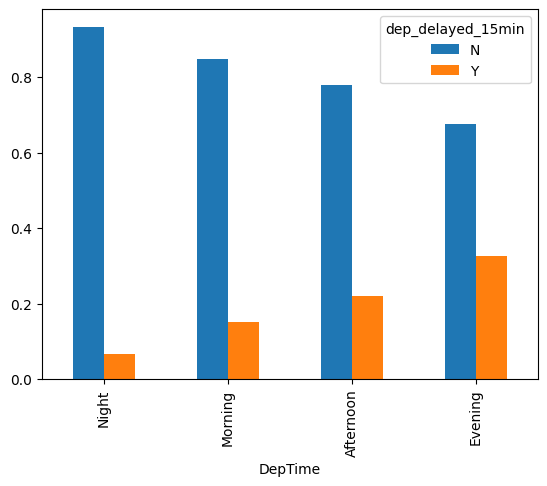

In [8]:
df[['DepTime', 'dep_delayed_15min']].groupby(
    'DepTime').value_counts(normalize=True).unstack().plot(kind='bar', stacked=False)
plt.show()

### Distance

In [9]:
df['Distance'] = pd.qcut(x=data['Distance'], q=5, labels=['Very short', 'Short', 'Medium', 'Long', 'Very long'])

/tmp/ipykernel_36262/1922755979.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df[['Distance', 'dep_delayed_15min']].groupby(


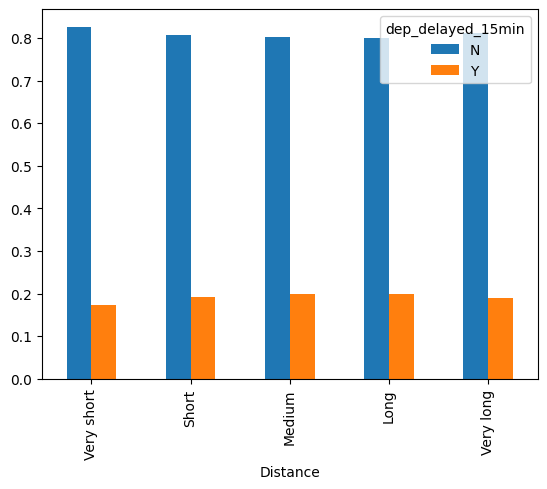

In [10]:
df[['Distance', 'dep_delayed_15min']].groupby(
    'Distance').value_counts(normalize=True).unstack().plot(kind='bar', stacked=False)
plt.show()

### Airports

In [11]:
airports = airportsdata.load('IATA')

In [12]:
def get_airport_location(airport_code):
    try:
        iata_code = airports[airport_code]['subd']
    except KeyError:
        if airport_code == 'PFN':
            iata_code = 'Florida'
        else:
            iata_code = 'Unknown'
    return iata_code

In [13]:
df['Origin'] = data['Origin'].apply(lambda x: get_airport_location(x))
df['Dest'] = data['Dest'].apply(lambda x: get_airport_location(x))

In [14]:
df.head()

,Month,DayofMonth,DayOfWeek,DepTime,UniqueCarrier,Origin,Dest,Distance,dep_delayed_15min
0,8,21,7,Evening,AA,Georgia,Texas,Long,N
1,4,20,3,Afternoon,US,Pennsylvania,Florida,Long,N
2,9,2,5,Afternoon,XE,North Carolina,Ohio,Short,N
3,11,25,6,Morning,OO,Colorado,Tennessee,Long,N
4,10,7,6,Evening,WN,Illinois,Nebraska,Short,Y


<Axes: xlabel='DayOfWeek'>

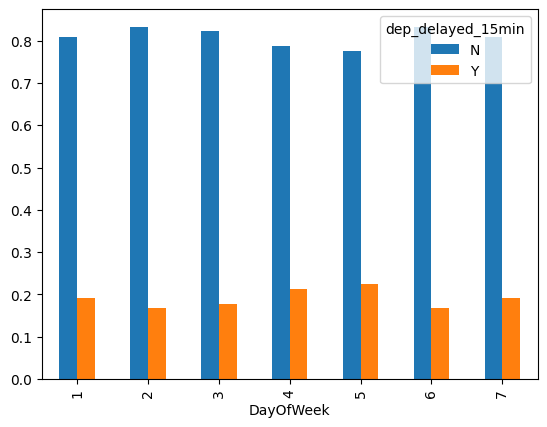

In [15]:
df[['DayOfWeek', 'dep_delayed_15min']].groupby(
    'DayOfWeek').value_counts(normalize=True).unstack().plot(kind='bar', stacked=False)

In [16]:
df['DayOfWeek'].describe()

count    100000.00000
mean          3.95183
std           1.99164
min           1.00000
25%           2.00000
50%           4.00000
75%           6.00000
max           7.00000
Name: DayOfWeek, dtype: float64

I want to plot the unique carrier number of flights (also with the delay and not deelay) by weighting them inversally w.r.t. the number of flights

<Axes: xlabel='UniqueCarrier'>

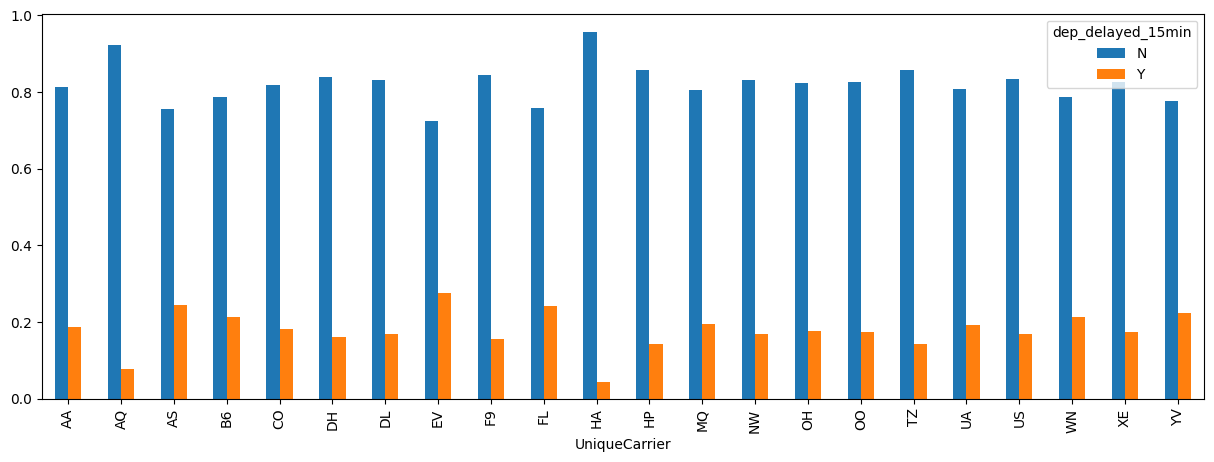

In [17]:
df[['UniqueCarrier', 'dep_delayed_15min']].groupby(
    'UniqueCarrier').value_counts(normalize=True).unstack().plot(kind='bar', stacked=False, figsize=(15, 5))

In [18]:
df['Weekend'] = df['DayOfWeek'].apply(lambda x: 1 if int(x) in [6, 7] else 0)

In [19]:
df.head()

,Month,DayofMonth,DayOfWeek,DepTime,UniqueCarrier,Origin,Dest,Distance,dep_delayed_15min,Weekend
0,8,21,7,Evening,AA,Georgia,Texas,Long,N,1
1,4,20,3,Afternoon,US,Pennsylvania,Florida,Long,N,0
2,9,2,5,Afternoon,XE,North Carolina,Ohio,Short,N,0
3,11,25,6,Morning,OO,Colorado,Tennessee,Long,N,1
4,10,7,6,Evening,WN,Illinois,Nebraska,Short,Y,1


In [20]:
def season(month, day):
    # return the season based on month and day

    complete_num = f"{month}{day}"
    complete_num = int(complete_num)

    if 320 <= complete_num <= 620:
        return 'Spring'
    elif 621 <= complete_num <= 922:
        return 'Summer'
    elif 923 <= complete_num <= 1221:
        return 'Fall'
    else:
        return 'Winter'

In [21]:
df['Season'] = df.apply(lambda x: season(x['Month'], x['DayofMonth']), axis=1)

<Axes: xlabel='Season'>

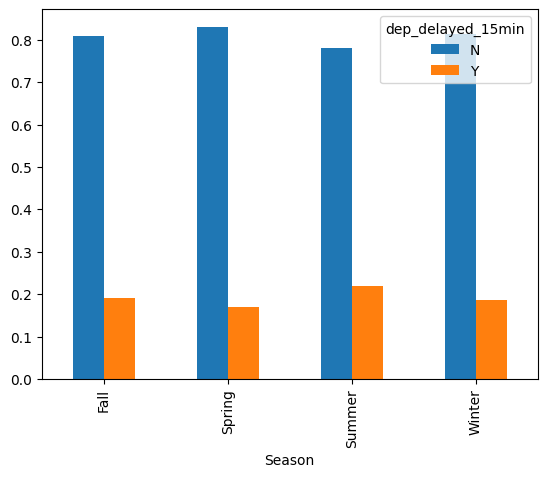

In [22]:
df[['Season', 'dep_delayed_15min']].groupby(
    'Season').value_counts(normalize=True).unstack().plot(kind='bar', stacked=False)

In [23]:
df['dep_delayed_15min'] = df['dep_delayed_15min'].apply(lambda x: 1 if x == 'Y' else 0)
df.rename(columns={'dep_delayed_15min': 'Delayed'}, inplace=True)

In [24]:
df = df.reindex(columns=['Month', 'DayofMonth', 'DayOfWeek', 'DepTime', 'Distance', 'Origin', 'Dest', 'UniqueCarrier', 'Weekend', 'Season', 'Delayed'])

In [25]:
df.head()

,Month,DayofMonth,DayOfWeek,DepTime,Distance,Origin,Dest,UniqueCarrier,Weekend,Season,Delayed
0,8,21,7,Evening,Long,Georgia,Texas,AA,1,Summer,0
1,4,20,3,Afternoon,Long,Pennsylvania,Florida,US,0,Spring,0
2,9,2,5,Afternoon,Short,North Carolina,Ohio,XE,0,Winter,0
3,11,25,6,Morning,Long,Colorado,Tennessee,OO,1,Fall,0
4,10,7,6,Evening,Short,Illinois,Nebraska,WN,1,Winter,1


In [142]:
import os
from concurrent.futures import ThreadPoolExecutor

import numpy as np

import networkx as nx

from pgmpy.models import BayesianNetwork
from pgmpy.inference import VariableElimination
from pgmpy.metrics import *
from pgmpy.metrics.bn_inference import *

from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold
from sklearn.metrics import *

import warnings

warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

# Split train test

In [140]:
X, y = df.drop(columns='Delayed'), df['Delayed']

In [143]:
kfold = RepeatedStratifiedKFold(n_splits=5, n_repeats=10, random_state=42)

In [145]:
for train_index, test_index in kfold.split(X, y):
    X_train, X_test, y_train, y_test = X.iloc[train_index], X.iloc[
        test_index], y.iloc[train_index], y.iloc[test_index]

In [128]:
for train_index, test_index in kfold.split(X_train, y_train):
    train_index = list(train_index)
    test_index = list(test_index)

    pippo = X_train.iloc[train_index]
    pluto = y_train.iloc[test_index]

    nb_model.fit(pd.concat([pippo, pluto], axis=1))

    y_pred = nb_model.predict(X_test)

    break

infer = VariableElimination(nb_model)

/home/matteo/Documenti/VSCODE/BayesianClassifier/.venv/lib/python3.11/site-packages/pgmpy/estimators/base.py:170: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  data.groupby([variable] + parents).size().unstack(parents)
/home/matteo/Documenti/VSCODE/BayesianClassifier/.venv/lib/python3.11/site-packages/pgmpy/estimators/base.py:170: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  data.groupby([variable] + parents).size().unstack(parents)
100%|██████████| 19927/19927 [00:17<00:00, 1122.66it/s]


# Naive Bayes

In [30]:
nb_model = BayesianNetwork([('Delayed', 'Month'), ('Delayed', 'DayofMonth'), ('Delayed', 'DayOfWeek'), ('Delayed', 'DepTime'), ('Delayed', 'Distance'), ('Delayed', 'Origin'), ('Delayed', 'Dest'), ('Delayed', 'UniqueCarrier'), ('Delayed', 'Weekend'), ('Delayed', 'Season')])

In [31]:
nb_model.nodes()

NodeView(('Delayed', 'Month', 'DayofMonth', 'DayOfWeek', 'DepTime', 'Distance', 'Origin', 'Dest', 'UniqueCarrier', 'Weekend', 'Season'))

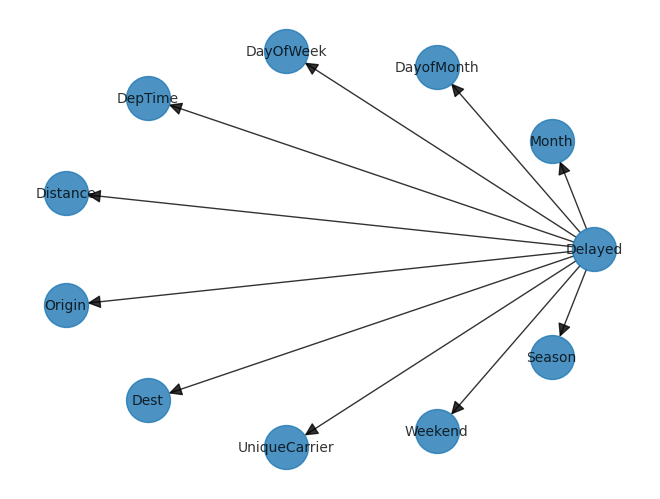

CPU times: user 380 ms, sys: 207 ms, total: 586 ms
Wall time: 251 ms


In [32]:
%%time
nx.draw_circular(nb_model, with_labels=True, arrowsize=20, node_size=1000, font_size=10, alpha=0.8)
plt.show()

In [35]:
nb_model.fit(pd.concat([X_train, y_train], axis=1))
nb_cpds = nb_model.get_cpds()
assert nb_model.check_model()

/home/matteo/Documenti/VSCODE/BayesianClassifier/.venv/lib/python3.11/site-packages/pgmpy/estimators/base.py:170: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  data.groupby([variable] + parents).size().unstack(parents)
/home/matteo/Documenti/VSCODE/BayesianClassifier/.venv/lib/python3.11/site-packages/pgmpy/estimators/base.py:170: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  data.groupby([variable] + parents).size().unstack(parents)


In [36]:
y_pred = nb_model.predict(X_test)
y_pred

  0%|          | 0/19927 [00:00<?, ?it/s]

100%|██████████| 19927/19927 [00:17<00:00, 1121.54it/s]


,Delayed
0,0
1,0
2,0
3,0
4,0
...,...
19995,0
19996,0
19997,0
19998,0


In [116]:
accuracy_score(y_test, y_pred['Delayed'])

0.8111

In [117]:
precision_score(y_test, y_pred['Delayed'])

0.0

In [118]:
recall_score(y_test, y_pred['Delayed'])

0.0

In [119]:
f1_score(y_test, y_pred['Delayed'])

0.0

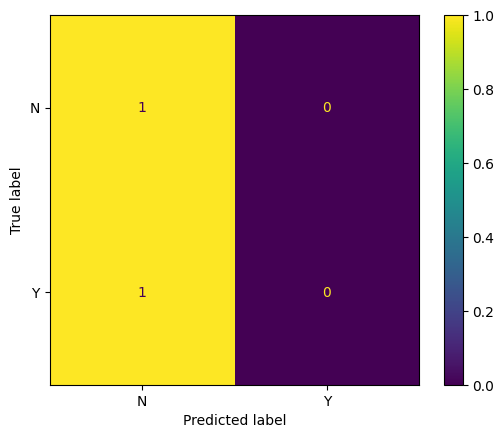

In [120]:
cm = confusion_matrix(y_test, y_pred['Delayed'], normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['N', 'Y'])
disp.plot()
plt.show()

In [52]:
roc_auc_score(y_true=y_test, y_score=y_pred, )

0.522835486894093

In [53]:
roc_curve(y_true=y_test, y_score=y_pred)

(array([0.        , 0.01097275, 1.        ]),
 array([0.        , 0.05664373, 1.        ]),
 array([inf,  1.,  0.]))

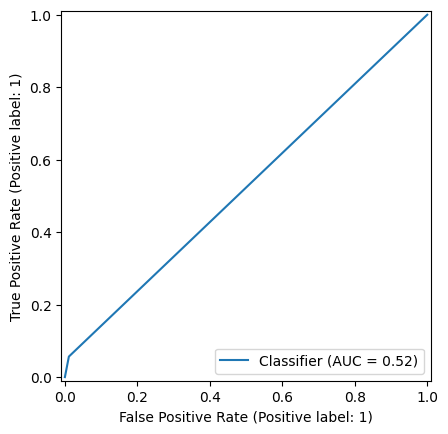

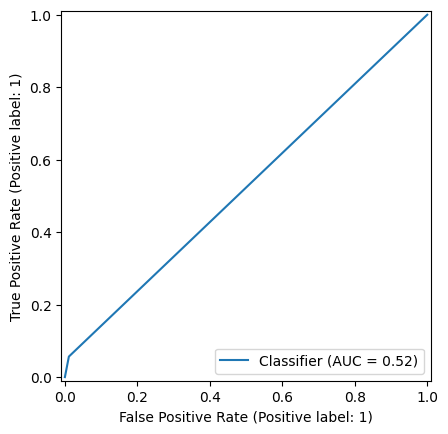

In [56]:
RocCurveDisplay.from_predictions(y_test, y_pred).plot()
plt.show()

# Model testing (structure not fitted)

In [162]:
correlation_score(nb_model, df)

0.0

In [163]:
log_likelihood_score(nb_model, df)

-inf

In [164]:
structure_score(nb_model, df, scoring_method="bic")

-2243848.7457803874